In [2]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 25 kB/s 


In [1]:
# On se place dans le drive (os?)
from google.colab import drive
drive.mount('/content/drive/')

data_path = "/content/drive/My Drive/Colab Notebooks/Competition Kaggle"

Mounted at /content/drive/


In [3]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Import de la donnée

In [4]:
train_full = pd.read_csv(data_path+'/train.csv')
test_full = pd.read_csv(data_path+'/test.csv')
sample_submission_full = pd.read_csv(data_path+'/sample_submission.csv')

train = train_full.sample(10000)

# Traitement de la donnée


In [5]:
train_full.shape

(1000000, 287)

In [6]:
train.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,...,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
920036,920036,0.230588,0.327526,0.340325,0.227288,0.463790,0.520095,0.353974,0.599278,0.638488,0.239871,0.416858,0.107221,0.221713,0.589831,0.316247,0.630210,0.315423,0.225355,0.195432,0.225655,0.516637,0.619392,1,0.012658,0.230664,0.220624,0.297747,0.143284,0.145825,0.197720,0.055985,0.190998,0.245335,0.558812,0.028921,0.108777,0.138921,0.399434,0.432154,...,1,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
925940,925940,0.207028,0.444630,0.085619,0.253114,0.768105,0.441910,0.625189,0.480884,0.547921,0.231688,0.018374,0.106359,0.270888,0.740988,0.173241,0.564115,0.288295,0.216101,0.224990,0.207865,0.483704,0.733738,1,0.012458,0.659344,0.255448,0.213415,0.172432,0.141304,0.226365,0.136220,0.165634,0.113189,0.033751,0.026692,0.112384,0.140047,0.219566,0.211332,...,1,1,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0
699658,699658,0.184011,0.336837,0.728813,0.303852,0.510206,0.387294,0.500001,0.694855,0.299192,0.258199,0.271542,0.110227,0.257635,0.466153,0.190552,0.420632,0.267594,0.180528,0.328072,0.195801,0.356040,0.734086,1,0.147114,0.342083,0.175168,0.300865,0.144448,0.254044,0.228807,0.211721,0.251644,0.250375,0.226719,0.013143,0.110704,0.143726,0.333545,0.266621,...,1,1,0,1,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
560150,560150,0.183200,0.454091,0.181737,0.304786,0.439483,0.519274,0.369914,0.656399,0.235787,0.160692,0.133832,0.105745,0.203849,0.590477,0.184216,0.517053,0.314802,0.183667,0.203364,0.214298,0.464874,0.750152,1,0.006971,0.514832,0.252006,0.242841,0.243378,0.139160,0.200628,0.060187,0.137756,0.336779,0.040976,0.014963,0.110497,0.267056,0.196208,0.238766,...,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
325525,325525,0.249131,0.662480,0.004376,0.246306,0.438141,0.353361,0.484331,0.612765,0.387167,0.325342,0.386787,0.165385,0.252723,0.654837,0.563368,0.476004,0.346042,0.235854,0.202759,0.186162,0.441818,0.636257,1,0.004440,0.305224,0.193477,0.233996,0.200432,0.138498,0.233640,0.057260,0.250445,0.180893,0.037439,0.019431,0.149479,0.186790,0.189417,0.225617,...,1,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1


In [7]:
train.isna().sum().sum()

0

### Identification des variables numériques / catégorielles


Text(0.5, 1.0, 'Distribution du nombre de valeurs uniques par variable')

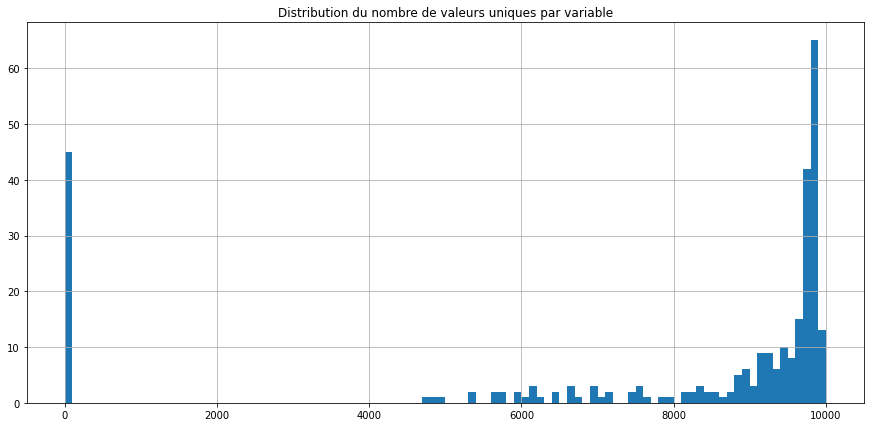

In [8]:
import matplotlib.pyplot as plt

unique_values = train.drop(['target'], axis=1).nunique()

unique_values.hist(bins=100, figsize=(15, 7))
plt.title('Distribution du nombre de valeurs uniques par variable')

On souhaite isoler la barre basse de cette distribution pour voir s'il existe un seuil trivial pour différencier les variables numériques (continues) et catégoriques (discrètes). D'autre part, on observe un outlier qui correspond à l'id unique.

Nombre de valeurs uniques maximal pour les séries contenant moins de 1000 valeurs uniques : 2
Nombre de valeurs uniques minimal pour les séries contenant plus de 1000 valeurs uniques : 4772


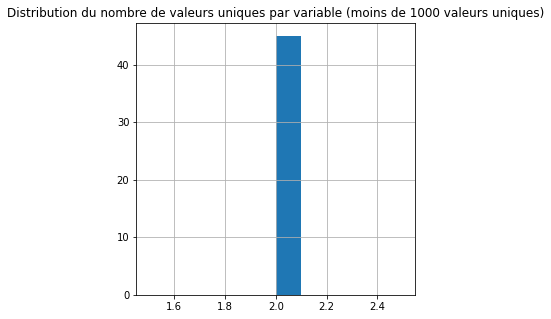

In [9]:
unique_values[unique_values < 1000].hist(bins=10, figsize=(5, 5))
plt.title('Distribution du nombre de valeurs uniques par variable (moins de 1000 valeurs uniques)')
print("Nombre de valeurs uniques maximal pour les séries contenant moins de 1000 valeurs uniques :",\
      unique_values[unique_values < 1000].max())
print("Nombre de valeurs uniques minimal pour les séries contenant plus de 1000 valeurs uniques :",\
      unique_values[unique_values >= 1000].min())

On oberve donc une différence nette entre les variables numériques, présentants au moins 50632 valeurs uniques, et les variables catégoriques qui possèdent au maximum 2 valeurs uniques.

In [10]:
cat_cols = unique_values[unique_values < 3].index
num_cols = unique_values[unique_values >= 3].index

print("Categorical columns : ", len(cat_cols))
print("Numerical columns : ", len(num_cols))

Categorical columns :  45
Numerical columns :  241


### Corrélations


#### Variables catégorielles


In [11]:
recap_cat = []

for col in train[cat_cols]:
    recap_cat.append([
        col,
        train[col].nunique(),
        train[col].mean(),
        train[col].min(),
        train[col].max(),
        train[col].corr(train['target'])
    ])

recap_cat = pd.DataFrame(recap_cat, columns=['Col','Num Unique','Mean','Min','Max','Corr'])
recap_cat= recap_cat.sort_values(by=['Corr'], ascending=False, key=abs)

recap_cat.head(5)

,Col,Num Unique,Mean,Min,Max,Corr
0,f22,2,0.5483,0,1,-0.514840
7,f247,2,0.6750,0,1,-0.049151
1,f43,2,0.2337,0,1,-0.040955
3,f243,2,0.2144,0,1,-0.037598
25,f265,2,0.4146,0,1,-0.031488


In [12]:
print(recap_cat.Min.max())
print(recap_cat.Max.min())

0
1


Les variables sont déjà normalisées entre 0 et 1.

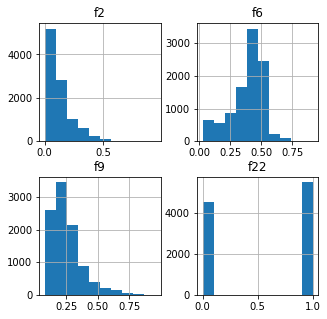

In [14]:
train.iloc[:, [3, 7, 10, 23]].hist(figsize=(5, 5))
plt.show()

On note la présence d'une variable catégorielle très anti-corrélée avec la target.

In [14]:
round((train[cat_cols].f22 & ~train['target']).sum() / len(train), 3) * 100

40.5

#### Variables numériques

In [15]:
recap_num = []

for col in train[num_cols]:
    recap_num.append([
        col,
        train[col].nunique(),
        train[col].mean(),
        train[col].min(),
        train[col].max(),
        train[col].corr(train['target'])
    ])

recap_num = pd.DataFrame(recap_num, columns=['Col','Num Unique','Mean','Min','Max','Corr'])
recap_num = recap_num.sort_values(by=['Corr'], ascending=False, key=abs)

recap_num.head(5)

,Col,Num Unique,Mean,Min,Max,Corr
178,f179,9860,0.068030,0.000577,0.849023,-0.139670
155,f156,8300,0.780172,0.029655,0.880144,0.083377
57,f58,9890,0.171877,0.064041,0.934064,-0.073436
68,f69,9553,0.209618,0.059023,0.921411,-0.073300
135,f136,6641,0.797415,0.188555,0.923364,0.064431


In [16]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test_full[num_cols] = scaler.transform(test_full[num_cols])

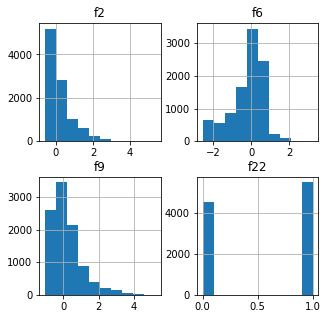

In [17]:
train.iloc[:, [3, 7, 10, 23]].hist(figsize=(5, 5))
plt.show()

# Modèle Standard


In [17]:
import time
time_ = time.time()
time.sleep(1)
print('Time to run this cell :', round(time.time()-time_, 2), 's')

Time to run this cell : 1.0 s


In [18]:
from sklearn.linear_model import LogisticRegression

time_ = time.time()

kf = StratifiedKFold(n_splits=3,random_state=1998,shuffle=True)

test_pred_lo = 0
fold = 1
total_auc_lr = 0

cols = list(num_cols)+list(cat_cols)

for train_idx, test_idx in kf.split(train[cols],train['target']):
    X_tr,X_val=train[cols].iloc[train_idx],train[cols].iloc[test_idx]
    y_tr,y_val=train['target'].iloc[train_idx],train['target'].iloc[test_idx]
    
    lr = LogisticRegression(n_jobs = -1, random_state = 42, C = 5, max_iter = 2000)
    lr.fit(X_tr, y_tr)
    
    valid_pred_lo = lr.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, valid_pred_lo)
    total_auc_lr += auc / 3
    print('Fold', fold, 'AUC :', auc)
    fold += 1
    
print('Total AUC score :', total_auc_lr)
t_lr = round(time.time()-time_, 2)
print('Time to run this cell :', t_lr, 's')

Fold 1 AUC : 0.8229686060571165
Fold 2 AUC : 0.8324771983393405
Fold 3 AUC : 0.8217441495368024
Total AUC score : 0.8257299846444197
Time to run this cell : 67.67 s


In [19]:
lr.predict_proba(X_tr)[:,1]

array([0.70408347, 0.96667968, 0.93440269, ..., 0.14453886, 0.25569953,
       0.97023596])

# Méthodes ensemblistes


## LGBMClassifier

In [21]:
time_ = time.time()


params={'objective' : 'binary',
    'eval_metric' : ['auc', 'error'],
    'max_depth' : 3,
    'num_leaves' : 7,
    'n_estimators' : 5000,
    'colsample_bytree' : 0.3,
    'subsample' : 0.5,
    'reg_alpha' : 18,
    'reg_lambda' : 17,
    'learning_rate' : 0.095,
    'random_state' : 2021}

cols = list(num_cols) + list(cat_cols)

preds_lgbm = np.zeros(test_full.shape[0])
kf = StratifiedKFold(n_splits=3,random_state=1998,shuffle=True)
auc=[]  # list contains auc for each fold
n=0
for train_idx, test_idx in kf.split(train[cols],train['target']):

    X_tr,X_val=train[cols].iloc[train_idx],train[cols].iloc[test_idx]
    y_tr,y_val=train['target'].iloc[train_idx],train['target'].iloc[test_idx]

    eval_metric = ["auc","logloss"]

    model = LGBMClassifier(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)],early_stopping_rounds=100,eval_metric=eval_metric,verbose=False)
    preds_lgbm += model.predict_proba(test_full[cols])[:,1]/kf.n_splits
    auc.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    gc.collect()
    print('Fold', n+1, 'AUC :', auc[n])
    n+=1  

total_auc_lgbm = sum(auc)/3
print('Total AUC score :', total_auc_lgbm)

t_lgbm = round(time.time()-time_, 2)
print('Time to run this cell :', t_lgbm, 's')

Fold 1 AUC : 0.8439094167434362
Fold 2 AUC : 0.8437989925140699
Fold 3 AUC : 0.8374649289072222
Total AUC score : 0.8417244460549095
Time to run this cell : 38.07 s


In [22]:
preds_lgbm

array([0.74564641, 0.24089988, 0.92632311, ..., 0.28531502, 0.68672373,
       0.44682605])

In [ ]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['valid_1']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
print(len(x_axis), len(results['training']['binary_logloss']))
ax[0].plot(x_axis, results['training']['auc'], label='Train')
ax[0].plot(x_axis, results['valid_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('LGBM AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['training']['binary_logloss'], label='Train')
ax[1].plot(x_axis, results['valid_1']['binary_logloss'], label='Test')
ax[1].legend()
ax[1].set_title('LGBM Binary Logloss')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

## XGBClassifier

In [ ]:
time_ = time.time()

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'n_jobs': -1,
    'n_estimators': 10000,
    'max_depth': 3,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'learning_rate': 0.01187,
    'random_state': 2021
}

cols = list(num_cols) + list(cat_cols)

preds = np.zeros(test_full.shape[0])
kf = StratifiedKFold(n_splits=3,random_state=1998,shuffle=True)
auc=[]  # list contains auc for each fold
n=0
for train_idx, test_idx in kf.split(train[cols],train['target']):
    X_tr,X_val=train[cols].iloc[train_idx],train[cols].iloc[test_idx]
    y_tr,y_val=train['target'].iloc[train_idx],train['target'].iloc[test_idx]

    model = XGBClassifier(**xgb_params)

    eval_metric = ["auc","error"]

    model.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)],early_stopping_rounds=200,eval_metric=eval_metric,verbose=False)
    preds += model.predict_proba(test_full[cols])[:,1]/kf.n_splits
    auc.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    gc.collect()
    print('Fold', n+1, 'AUC :', auc[n])
    n+=1  

total_auc_xgb = sum(auc)/3
print('Total AUC score :', total_auc_xgb)

t_xgb = round(time.time()-time_, 2)
print('Time to run this cell :', t_xgb, 's')

In [ ]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

## CatBoostClassifier

In [ ]:
time_ = time.time()

cb_params = {
    'loss_function' : 'CrossEntropy',
    'eval_metric' : 'AUC',
    'iterations' : 10000,
    'grow_policy' : 'SymmetricTree',
    'use_best_model' : True,
    'depth' : 5,
    'l2_leaf_reg' : 3.0,
    'random_strength' : 1.0,
    'learning_rate' : 0.1,
    'verbose' : 0,
    'random_state': 2021
}

cols = list(num_cols) + list(cat_cols)

preds = np.zeros(test_full.shape[0])
kf = StratifiedKFold(n_splits=3,random_state=1998,shuffle=True)
auc=[]  # list contains auc for each fold
n=0
for train_idx, test_idx in kf.split(train[cols],train['target']):
    X_tr,X_val=train[cols].iloc[train_idx],train[cols].iloc[test_idx]
    y_tr,y_val=train['target'].iloc[train_idx],train['target'].iloc[test_idx]

    model = CatBoostClassifier(**cb_params)

    eval_metric = ["auc","error"]

    model.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)],early_stopping_rounds=200)
    preds += model.predict_proba(test_full[cols])[:,1]/kf.n_splits
    auc.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    gc.collect()
    print('Fold', n+1, 'AUC :', auc[n])
    n+=1  

total_auc_cb = sum(auc)/3
print('Total AUC score :', total_auc_cb)

t_cb = round(time.time()-time_, 2)
print('Time to run this cell :', t_cb, 's')

In [ ]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['CrossEntropy'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['AUC'], label='Train')
ax[0].plot(x_axis, results['validation_1']['AUC'], label='Test')
ax[0].legend()
ax[0].set_title('CatBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['CrossEntropy'], label='Train')
ax[1].plot(x_axis, results['validation_1']['CrossEntropy'], label='Test')
ax[1].legend()
ax[1].set_title('CatBoost CrossEntropy')
ax[1].set_ylabel('CrossEntropy Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()
plt.title('AUC / Training Time Ratio')

models = ['Log Reg', 'LGBM', 'XGBoost', 'CatBoost']
times = [t_lr, t_lgbm, t_xgb, t_cb]
aucs = [total_auc_lr, total_auc_lgbm, total_auc_xgb, total_auc_cb]
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for idx, model in enumerate(models):
    
    x, y = times[idx], aucs[idx]
    #scale = 200.0 * np.random.rand(n)
    ax.scatter(x, y, c=color[idx], label=model,
               alpha=1, edgecolors='none')

ax.set_xlabel('Training Time (s)')
ax.set_ylabel('AUC')
ax.legend()
ax.grid(True)

plt.show()

# Modèle final

,id,target
0,1000000,0.700092
1,1000001,0.242626
2,1000002,0.898198
3,1000003,0.868010
4,1000004,0.264795


In [3]:
train_full = pd.read_csv(data_path+'/train.csv').head(100000)
test_full = pd.read_csv(data_path+'/test.csv')
sample_submission_full = pd.read_csv(data_path+'/sample_submission.csv')

unique_values = train_full.drop(['target'], axis=1).nunique()

cat_cols = unique_values[unique_values < 3].index
num_cols = unique_values[unique_values >= 3].index

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train_full[num_cols] = scaler.fit_transform(train_full[num_cols])
test_full[num_cols] = scaler.transform(test_full[num_cols])

In [6]:
import time

time_ = time.time()


params={'objective' : 'binary',
    'eval_metric' : ['auc', 'error'],
    'max_depth' : 3,
    'num_leaves' : 7,
    'n_estimators' : 5000,
    'colsample_bytree' : 0.3,
    'subsample' : 0.5,
    'reg_alpha' : 18,
    'reg_lambda' : 17,
    'learning_rate' : 0.095,
    'random_state' : 2021}

cols = list(num_cols) + list(cat_cols)

preds_lgbm = np.zeros(test_full.shape[0])
kf = StratifiedKFold(n_splits=3,random_state=1998,shuffle=True)
auc=[]  # list contains auc for each fold
n=0
for train_idx, test_idx in kf.split(train_full[cols],train_full['target']):

    X_tr,X_val=train_full[cols].iloc[train_idx],train_full[cols].iloc[test_idx]
    y_tr,y_val=train_full['target'].iloc[train_idx],train_full['target'].iloc[test_idx]

    eval_metric = ["auc","logloss"]

    model = LGBMClassifier(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)],early_stopping_rounds=100,eval_metric=eval_metric,verbose=False)
    preds_lgbm += model.predict_proba(test_full[cols])[:,1]/kf.n_splits
    auc.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    gc.collect()
    print('Fold', n+1, 'AUC :', auc[n])
    n+=1  

total_auc_lgbm = sum(auc)/3
print('Total AUC score :', total_auc_lgbm)

t_lgbm = round(time.time()-time_, 2)
print('Time to run this cell :', t_lgbm, 's')

Fold 1 AUC : 0.8525831033336476
Fold 2 AUC : 0.8535017683288624
Fold 3 AUC : 0.8516513310824347
Total AUC score : 0.8525787342483149
Time to run this cell : 157.78 s


In [ ]:
submit_df = sample_submission_full
submit_df['target'] = preds_lgbm.ravel()
submit_df.to_csv(data_path+"/LGBM_Submission.csv", index=False)
submit_df.head()